In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, TimeDistributed
import pandas as pd

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.ylim(0,1)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [3]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [4]:
def create_time_series_data(raw_train_df, nbf_features, nbf_outputs, column_key, column_suffix="", include_target_outputs=True):
    nbf_columns = nbf_features + nbf_outputs
    time_series_df, time_series = sliding_window_algorithm(raw_train_df, nbf_columns, nbf_features, nbf_outputs, column_key, column_suffix, include_target_outputs)
    return time_series, time_series_df


def sliding_window_algorithm(raw_data_df, nbf_columns, input_window, output_window, column_key, column_suffix, include_target_outputs, string_array=False):
    raw_data = raw_data_df[column_key].to_numpy()
    dim0 = raw_data.shape[0] - (nbf_columns - 1) # Number of time-slices
    dim1 = nbf_columns # Time-step length including input window and output window
    
    if string_array:
        data = np.empty((dim0,dim1), dtype=object) # Time series matrix
    else:
        data = np.zeros((dim0,dim1)) # Time series matrix

    data[0, :] = raw_data[:dim1] # First initial sample/time-slice (n equals 0)
    n = 1 # n is the count variable
    
    # Looping through the initial input data and constucting the 
    # time series data based on the sliding window approach. 
    # See the report for more descriptions
    for j in range(dim1, raw_data.shape[0]):
        data[n, :-1] = data[n-1, 1:]
        data[n, nbf_columns-1:] = raw_data[j]
        n += 1

    if include_target_outputs:
        # Creating dataframe    
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+1)]
        if(output_window > 1):
            output_names = [f"y{i}_{column_suffix}" for i in range(1,output_window+1)]    
        else:
            output_names = [f"y_{column_suffix}"]
        
        time_series_df = pd.DataFrame(data=data, columns=feature_names+output_names)
    else:
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+2)]
        time_series_df = pd.DataFrame(data=data, columns=feature_names)

    return time_series_df, data

# Own Dataset

In [244]:
# Training data
dataset_df = pd.read_csv("MAIN_DATASET.csv")[["NO5_price", "NO5_load_actual","NO5_load_delta", "NO5_generation_actual", "NO5_generation_delta", "dato_id","date_time"]][:-7381]; print(dataset_df.shape)

display(dataset_df.tail(3))


scaler = MinMaxScaler()
print("***",dataset_df["NO5_price"].values.reshape(-1,1).shape)

dataset_df["NO5_price"] = scaler.fit_transform(dataset_df["NO5_price"].values.reshape(-1,1))
dataset_df["NO5_load_actual"] = scaler.fit_transform(dataset_df["NO5_load_actual"].values.reshape(-1,1))
dataset_df["NO5_load_delta"] = scaler.fit_transform(dataset_df["NO5_load_delta"].values.reshape(-1,1))
dataset_df["NO5_generation_actual"] = scaler.fit_transform(dataset_df["NO5_generation_actual"].values.reshape(-1,1))
dataset_df["NO5_generation_delta"] = scaler.fit_transform(dataset_df["NO5_generation_delta"].values.reshape(-1,1))

# Forecast solutions
# training_df, forcast_sol_df = train_test_split(training_df, shuffle=False, test_size=0.2, random_state=4155)

# Displaying the loaded data
# display(training_df.tail(3))
# print(training_df.shape)
# display(forcast_sol_df.head(3))
# print(forcast_sol_df.shape)

# print(training_df.max())

# print(training_df.min())
# print(forcast_sol_df.max())
# print(forcast_sol_df.min())

(44280, 7)


,NO5_price,NO5_load_actual,NO5_load_delta,NO5_generation_actual,NO5_generation_delta,dato_id,date_time
44277,35.29,2490,-423,6910,-3275,2021-01-21 09:00:00+01:00,2021-01-21-09
44278,33.01,2499,-460,6568,-3186,2021-01-21 10:00:00+01:00,2021-01-21-10
44279,33.38,2460,-412,6722,-3267,2021-01-21 11:00:00+01:00,2021-01-21-11


*** (44280, 1)


## SeqToVec
Returning only the last output

In [290]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = horizon = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO5_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")


# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44208, 73)
(44208, 73)
(34272, 72, 1) (34272, 1)
(6581, 72, 1) (6581, 1)
(3355, 72, 1) (3355, 1)


In [277]:
print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{y_valid.shape=}")

eta = 0.002
batch_size = 100
model = keras.models.Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, 72]),
    LSTM(20, return_sequences=True),
    TimeDistributed(keras.layers.Dense(1))
])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=eta)
model.compile(loss="mse", optimizer=opt)

callbacks = [learning_rate_reduction]

print(X_train.shape)
print(y_train.shape)

history = model.fit(np.swapaxes(X_train, 1, 2), y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(np.swapaxes(X_valid, 1, 2), y_valid),
                    callbacks= callbacks)   

X_train.shape=(34272, 72, 1)
y_train.shape=(34272, 1)
X_valid.shape=(6581, 72, 1)
y_valid.shape=(6581, 1)
(34272, 72, 1)
(34272, 1)
Epoch 1/20
343/343 [==============================] - 2s 5ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 2/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0118
Epoch 3/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0119
Epoch 4/20
335/343 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
343/343 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0114
Epoch 5/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 6/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 7/20
343/343 [==============================] - 1s 3ms/step - loss: 7.9667e-04 - val_loss: 0.0041
Epoch 8/20
343/343

In [278]:
model.evaluate(np.swapaxes(X_valid, 1,2), y_valid)

206/206 [==============================] - 0s 1ms/step - loss: 0.0027


0.0027136141434311867

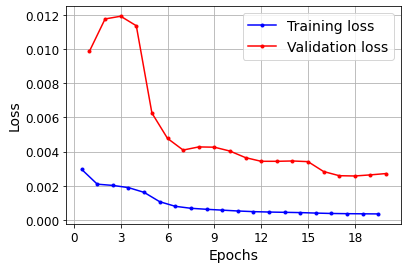

In [279]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

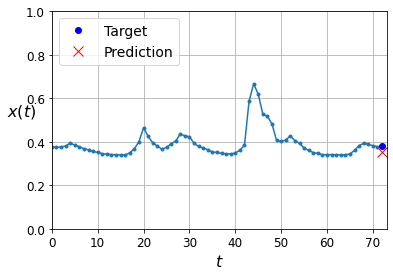

In [280]:
y_pred = model.predict(np.swapaxes(X_valid, 1,2))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [281]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = horizon = 24

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO5_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")


# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44185, 96)
(44185, 96)
(34272, 72, 1) (34272, 24)
(6581, 72, 1) (6581, 24)
(3332, 72, 1) (3332, 24)


In [282]:
np.random.seed(43) # not 42, as it would give the first series in the train set

X_new = X_test[-1:, :]
Y_new = np.expand_dims(y_test[-1:, :], 2)

display(dataset_df[["NO5_price", "date_time"]].tail(1))

print(f"{X_new.shape=}")
print(f"{Y_new.shape=}")

# X = X_new
X = np.swapaxes(X_new, 1,2)

print(X.shape)

for step_ahead in range(horizon):
    # y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    y_pred_one = model.predict(X[:, :, step_ahead:])

    print(f"{y_pred_one.shape=}")
    #y_pred_one = y_pred_one[:, np.newaxis, :]

    # X = np.concatenate([X, y_pred_one], axis=1)
    print(f"{y_pred_one.shape=}")

    X = np.concatenate([X, y_pred_one], axis=2)
    print(f"{X.shape=}")

print(f"{X.shape=}")
Y_pred = X[:, n_steps:]
Y_pred = X[:,:, n_steps:]

,NO5_price,date_time
44279,0.291576,2021-01-21-11


X_new.shape=(1, 72, 1)
Y_new.shape=(1, 24, 1)
(1, 1, 72)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 73)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 74)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 75)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 76)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 77)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 78)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 79)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 80)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 81)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 82)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 83)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 84)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1

In [291]:
Y_pred = np.swapaxes(Y_pred, 1,2)
print(Y_pred.shape)

(1, 24, 1)


Saving figure forecast_ahead_plot


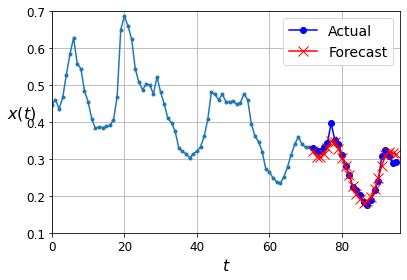

MSE: 0.0002782513119321815


In [286]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.ylim(0,1)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.ylim(0.10,0.70)
plt.show()

mse = keras.metrics.mean_squared_error(Y_new, Y_pred)
print("MSE:",np.mean(mse))

# Do not touch above

Now let's use this model to predict the next 24 values. We first need to regenerate the sequences with 23 more time steps.

In [254]:
# Time series slicing parameters
nbf_features = input_window = 1
nbf_outputs = output_window = horizon = 24
n_steps = time_steps = 72

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO5_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")

# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

# X_train = np.expand_dims(X_train, axis=1)
# X_valid = np.expand_dims(X_valid, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# print(X_train.shape, y_train.shape)
# print(X_valid.shape, y_valid.shape)
# print(X_test.shape, y_test.shape)

print("before")
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

train_start_idx = X_train.shape[0]%time_steps
X_train = X_train[train_start_idx: , :] # 
y_train = y_train[train_start_idx: , :] # 

batch_size_train = X_train.shape[0] // time_steps
x_train_RNN = X_train.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN = y_train.copy()
y_train_RNN = y_train_RNN.reshape((batch_size_train, time_steps, nbf_outputs))


# Validation 
valid_start_idx = X_valid.shape[0]%time_steps
X_valid = X_valid[valid_start_idx: , :] # 
y_valid = y_valid[valid_start_idx: , :] # 

batch_size_valid = X_valid.shape[0] // time_steps
x_valid_RNN = X_valid.reshape((batch_size_valid, time_steps, nbf_features))
y_valid_RNN = y_valid.copy()
y_valid_RNN = y_valid_RNN.reshape((batch_size_valid, time_steps, nbf_outputs))

# Test 
test_start_idx = X_test.shape[0]%time_steps
X_test = X_test[test_start_idx: , :] # 
y_test = y_test[test_start_idx: , :] # 

batch_size_test = X_test.shape[0] // time_steps
x_test_RNN = X_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, nbf_outputs))

X_train = x_train_RNN#.swapaxes(1,2)
y_train = y_train_RNN#.squeeze()   

X_valid = x_valid_RNN#.swapaxes(1,2)   
y_valid = y_valid_RNN#.squeeze()   

X_test = x_test_RNN#.swapaxes(1,2)   
y_test = y_test_RNN#.squeeze()

print("After")
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44256, 25)
(44256, 25)
before
(34272, 1) (34272, 24)
(6581, 1) (6581, 24)
(3403, 1) (3403, 24)
After
(476, 72, 1) (476, 72, 24)
(91, 72, 1) (91, 72, 24)
(47, 72, 1) (47, 72, 24)


In [263]:
eta = 0.002
batch_size = 100
model = keras.models.Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, nbf_features]),
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, nbf_features]),
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    LSTM(20, return_sequences=True),
    TimeDistributed(keras.layers.Dense(24))
])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=eta)
model.compile(loss="mse", optimizer=opt)

callbacks = [learning_rate_reduction]

print(X_train.shape)
print(y_train.shape)

history = model.fit(X_train, y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks= callbacks)   

(476, 72, 1)
(476, 72, 24)
Epoch 1/20
5/5 [==============================] - 2s 469ms/step - loss: 0.0909 - val_loss: 0.0156
Epoch 2/20
5/5 [==============================] - 0s 36ms/step - loss: 0.0699 - val_loss: 0.0118
Epoch 3/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0456 - val_loss: 0.0157
Epoch 4/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0281 - val_loss: 0.0144
Epoch 5/20
5/5 [==============================] - ETA: 0s - loss: 0.0164
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
5/5 [==============================] - 0s 37ms/step - loss: 0.0164 - val_loss: 0.0204
Epoch 6/20
5/5 [==============================] - 0s 40ms/step - loss: 0.0124 - val_loss: 0.0237
Epoch 7/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0114 - val_loss: 0.0216
Epoch 8/20
5/5 [==============================] - ETA: 0s - loss: 0.0102
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257

y_horizon_pred.shape=(1, 72, 24)
y_horizon_target.shape=(1, 72, 24)


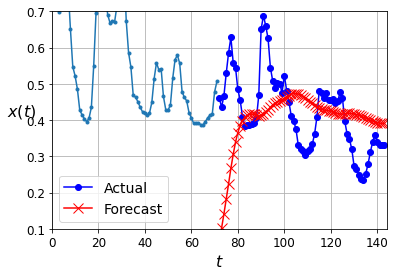

In [271]:
X_new = X_test[-2:-1, :, :]
y_horizon_pred = model.predict(X_new)
print(f"{y_horizon_pred.shape=}")

y_horizon_target = y_test[-1:, :, :]
print(f"{y_horizon_target.shape=}")


plot_multiple_forecasts(X_new, y_horizon_target, y_horizon_pred)
plt.ylim(0.10,0.70)
plt.show()

Now let's predict the next 24 values one by one:

In [261]:

# X = np.swapaxes(X_valid, 1, 2)
X = X_valid
print(X.shape)

for step_ahead in range(24):
    y_pred_one = model.predict(X[-1:,step_ahead:,:])

    #print(f"{y_pred_one.shape=}")
    #y_pred_one = y_pred_one[:, np.newaxis, :]
    
    print(f"{y_pred_one.shape=}")
    #y_pred_one = y_pred_one[:, np.newaxis, :]
    #print(f"{y_pred_one.shape=}")
    
    print(f"{X.shape=}")

    X = np.concatenate([X, y_pred_one], axis=1)
    print(f"{X.shape=}")

print(f"{X.shape=}")
#X = X.swapaxes(1,2)
Y_pred = X[:, n_steps:, 0]
print(f"{Y_pred.shape=}")

(91, 72, 1)
y_pred_one.shape=(1, 72, 1)
X.shape=(91, 72, 1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 91 and the array at index 1 has size 1

In [257]:
Y_pred.shape

(91, 0)

In [206]:

mse = keras.metrics.mean_squared_error(y_valid, np.expand_dims(Y_pred, 1))
print(mse.shape)
print(np.mean(mse))

InvalidArgumentError: Incompatible shapes: [91,1,0] vs. [91,72,24] [Op:SquaredDifference]

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [96]:
# print(X_valid[:, -1].shape)
# Y_naive_pred = np.tile(X_valid[:, -1], 24) # take the last time step value, and repeat it 10 times
# print(Y_naive_pred.shape)
# print(y_valid.shape)
# np.mean(keras.metrics.mean_squared_error(y_valid, Y_naive_pred))

In [15]:
# X = X_valid#[-1:, :]
# X = np.swapaxes(X, 1,2)
# print(X.shape)

# for step_ahead in range(horizon):
#     y_pred_one = model.predict(X)
#     print(f"{y_pred_one.shape=}")
    
#     # y_pred_one = y_pred_one[:, np.newaxis, :]
#     # print(f"{y_pred_one.shape=}")
    
#     X = np.concatenate([X, y_pred_one], axis=1)

# Y_pred = X[:, n_steps:, 0]

In [16]:
# X_new = X_test[-1:, :]
# print(X_new.shape)
# Y_new = np.expand_dims(y_test[-1:, :], 2)
# Y_pred = model.predict(X_new.swapaxes(1,2))#[..., np.newaxis]

# print(Y_pred.shape)

In [17]:
# plot_multiple_forecasts(X_new, Y_new, Y_pred)
# plt.ylim(0.10,0.70)
# plt.show()

Now let's create an RNN that predicts all 10 next values at once:

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 72 to 72+9 based on time steps 0 to 71, it will forecast time steps 1 to 24 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 72 to 72+9 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [149]:
Y = np.empty((time_series.shape[0], n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n_steps, 0]


In [150]:
X_train.shape, y_train.shape

((476, 72, 1), (476, 72, 24))

In [151]:
np.random.seed(42)

#n_steps = 48
dataset_len = X_train.shape[0] + X_train.shape[1] + X_train.shape[2]

Y = np.empty((dataset_len, n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n_steps, 0]

print(f"{Y.shape=}")
Y_train = Y[:y_train.shape[0]]
Y_valid = Y[y_train.shape[0]:y_train.shape[0]+y_valid.shape[0]]
Y_test = Y[y_train.shape[0]+y_valid.shape[0]:]

Y.shape=(549, 72, 24)


In [152]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(476, 72, 1) (476, 72, 24)
(91, 72, 1) (73, 72, 24)
(47, 72, 1) (0, 72, 24)


(44185, 96)
(44185, 96)
(34272, 72) (34272, 24)
(6581, 72) (6581, 24)
(3332, 72) (3332, 24)
After
(34272, 1, 72) (34272, 1, 24)
(6581, 72) (6581, 24)
(3332, 72) (3332, 24)


In [162]:
np.random.seed(42)
tf.random.set_seed(42)

eta = 0.002
batch_size = 100

model = keras.models.Sequential([
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=eta)
model.compile(loss="mse", optimizer=opt)

callbacks = [learning_rate_reduction]

print(X_train.shape)
print(y_train.squeeze().shape)

history = model.fit(X_train, y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks= callbacks)

(476, 72, 1)
(476, 72, 24)
Epoch 1/20
5/5 [==============================] - 1s 202ms/step - loss: 0.0895 - val_loss: 0.0151
Epoch 2/20
5/5 [==============================] - 0s 36ms/step - loss: 0.0673 - val_loss: 0.0127
Epoch 3/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0452 - val_loss: 0.0185
Epoch 4/20
5/5 [==============================] - 0s 36ms/step - loss: 0.0313 - val_loss: 0.0185
Epoch 5/20
5/5 [==============================] - ETA: 0s - loss: 0.0214
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
5/5 [==============================] - 0s 36ms/step - loss: 0.0214 - val_loss: 0.0158
Epoch 6/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 7/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0129 - val_loss: 0.0177
Epoch 8/20
4/5 [=======================>......] - ETA: 0s - loss: 0.0118
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257

3/3 [==============================] - 0s 6ms/step - loss: 0.0149


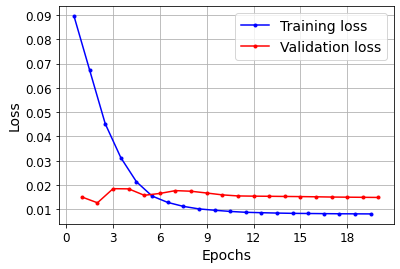

In [163]:
model.evaluate(X_valid, y_valid)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [180]:
np.random.seed(43)

# series = generate_time_series(1, 50 + 10)
# X_new, Y_new = series[:, :50, :], series[:, 50:, :]

#print(f"{X_test.shape=}")

print("X_test.shape:",X_test.shape)
print("y_test.shape:",y_test.shape)


X_new = X_test[-1:, :, :]
# Y_new = np.expand_dims(y_test[-1:, :], 2)
Y_new = y_test[-1:, :, :]
# Y_new = y_test[-1:, -1:, :].swapaxes(1,2)

# Y_new = Y_new[..., np.newaxis].squeeze(0)
Y_new = Y_new[:, -1]
Y_new = Y_new[..., np.newaxis]


print("X_new.shape:",X_new.shape)
print("Y_new.shape:",Y_new.shape)

Y_pred = model.predict(X_new)
print("Y_pred.shape:",Y_pred.shape)

Y_pred = Y_pred[:, -1]
print("Y_pred[:, -1]:",Y_pred.shape)

Y_pred = Y_pred[..., np.newaxis]
print("Y_pred[..., np.newaxis]:",Y_pred.shape)



# Y_pred = model.predict(X_new)
# print(f"Before: {Y_pred.shape=}")

# Y_pred = Y_pred[:, -1][..., np.newaxis]

# print(f"{X_new.shape=}")
# print(f"{Y_new.shape=}")
# print(f"After: {Y_pred.shape=}")

X_test.shape: (47, 72, 1)
y_test.shape: (47, 72, 24)
X_new.shape: (1, 72, 1)
Y_new.shape: (1, 24, 1)
Y_pred.shape: (1, 72, 24)
Y_pred[:, -1]: (1, 24)
Y_pred[..., np.newaxis]: (1, 24, 1)


(1, 72, 1)
(1, 24, 1)
(1, 24, 1)


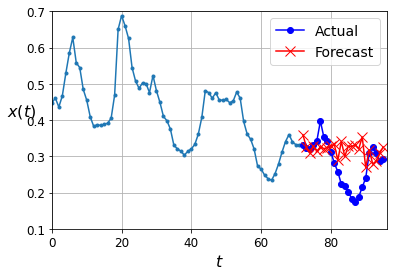

In [181]:
print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.ylim(0.10,0.70)
plt.show()